In [2]:
%%capture
! pip install librosa
! pip install torch

In [3]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from CustomDataset import CustomDataset
import numpy as np
from EuclideanDistanceLoss import EuclideanDistanceLoss 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from Misc import Misc
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F

In [4]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"
# Dimensions of the living room
X_MIN = -4000
X_MAX = 500
Y_MIN = -4000
Y_MAX = 2000
MISC = Misc(start_time=0, end_time=50000, sr=44100, target_sr=16000)
EUCLIDEAN_LOSS = EuclideanDistanceLoss()

## Read Data

In [5]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [6]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)


## Normalize Coordinates

In [7]:
def normalize_coordinates(centroids):
    room_width = X_MAX - X_MIN
    room_height = Y_MAX - Y_MIN

    centroids[:, 0] = (centroids[:, 0] - X_MIN) / room_width
    centroids[:, 1] = (centroids[:, 1] - Y_MIN) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## Preprocessing

In [8]:
preprocessed_data_mfcc_h1, preprocessed_data_rms_h1, preprocessed_data_zcr_h1, preprocessed_data_mel_h1 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h1)
preprocessed_data_mfcc_h2, preprocessed_data_rms_h2, preprocessed_data_zcr_h2, preprocessed_data_mel_h2 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h2)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 104/104 [00:04<00:00, 21.90it/s]


## Visualization of the data preprocessed (MFCC)

In [9]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 36)
Preprocessed MFCC Human 1 data:  (1000, 4, 20, 36)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 36)
Preprocessed MFCC Human 2 data:  (104, 4, 20, 36)


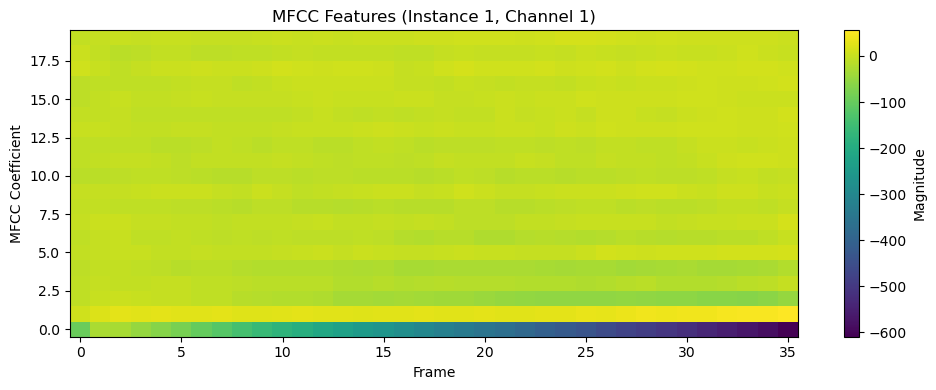

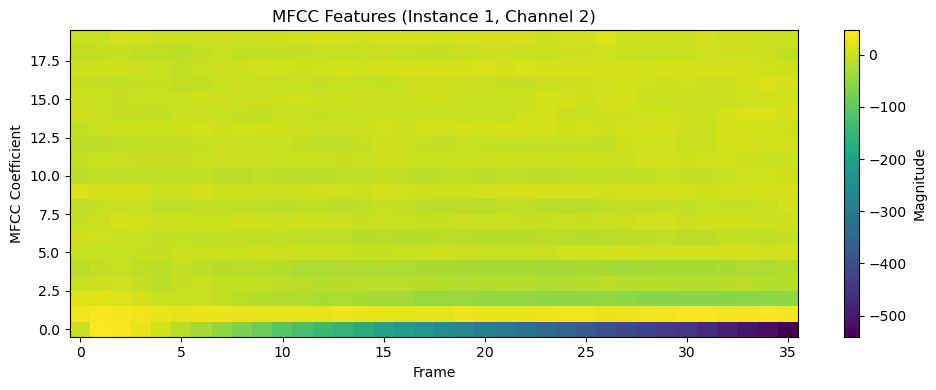

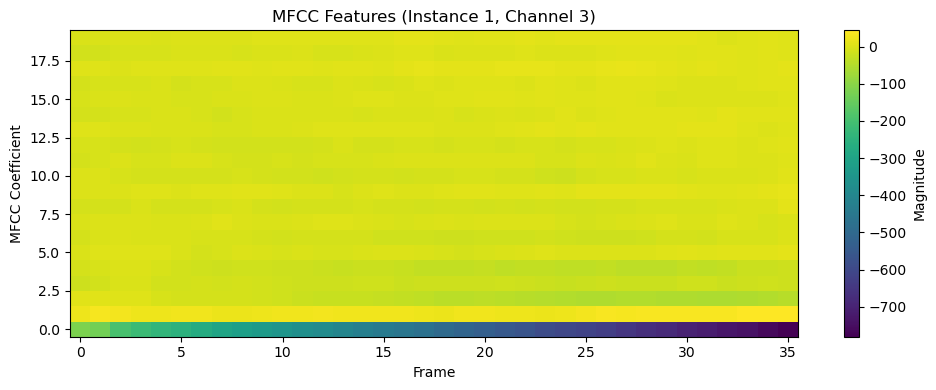

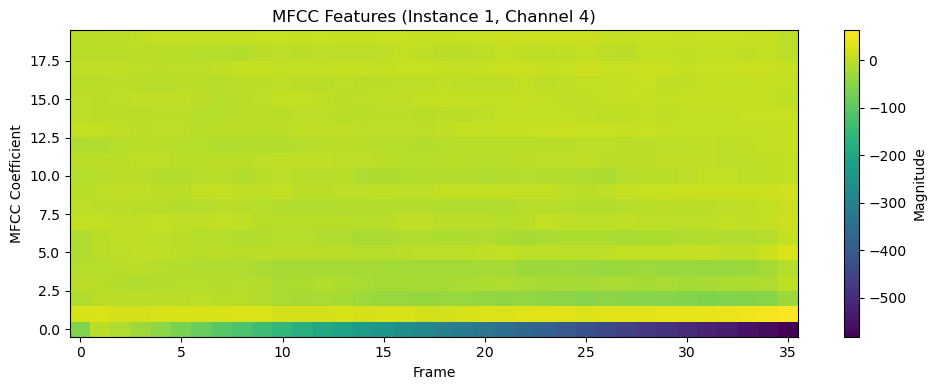

In [10]:
# Plot audio features for 1 instance and 1 channel
instance_index = 0
for channel_index in range(preprocessed_data_mfcc_h2.shape[1]):
    mfcc_features = preprocessed_data_mfcc_h2[instance_index, channel_index]
    MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, mfcc=mfcc_features)

## Reduction of 4 Microphones to 1: Summation of MFCC Images

Summed MFCC images for instance 1 in human 2 :


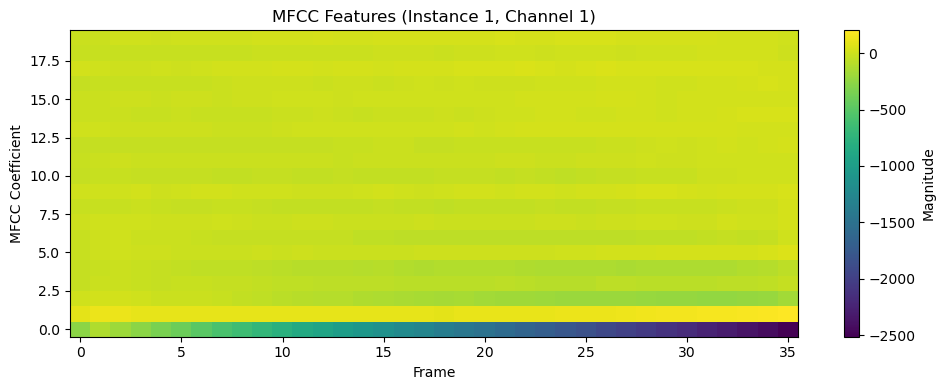

In [11]:
def sum_mfcc_images(data):
    num_instances, num_channels, num_mfcc, feature_size = data.shape
    
    summed_mfcc_images = np.zeros((num_instances, num_mfcc, feature_size))
    
    for instance_index in range(num_instances):
        mfcc_images = data[instance_index]  # Shape: (num_channels, num_mfcc, feature_size)
        summed_mfcc_images[instance_index] = np.sum(mfcc_images, axis=0)
    
    return summed_mfcc_images

summed_mfcc_images_h1 = sum_mfcc_images(preprocessed_data_mfcc_h1)
summed_mfcc_images_h2 = sum_mfcc_images(preprocessed_data_mfcc_h2)

instance_index_to_check = 0
print("Summed MFCC images for instance", instance_index_to_check + 1, "in human 2 :")

mfcc_features_h2 = summed_mfcc_images_h2[instance_index_to_check]
MISC.plot_audio_features(instance_index=instance_index_to_check, chan_index=0, mfcc=mfcc_features_h2)


## Reduction of 4 Microphones to 1: Concatenation of MFCC Images

Concatenated MFCC images for instance 1 in human 2 :


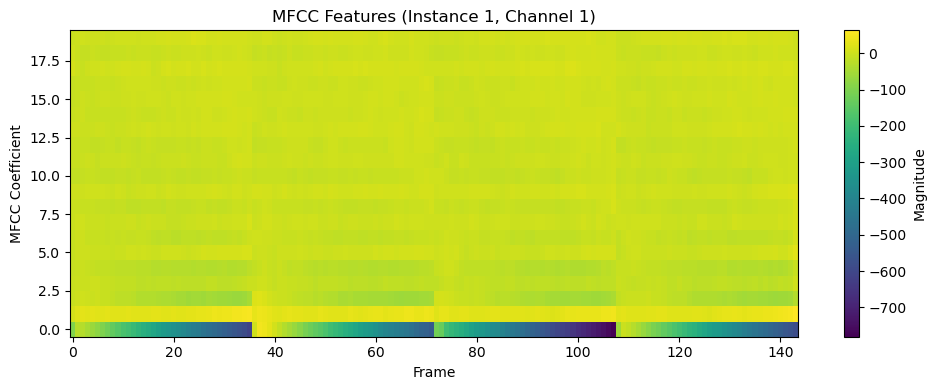

In [12]:
def concatenate_mfcc_images(data):
    num_instances, num_channels, num_mfcc, feature_size = data.shape
    
    concatenated_mfcc_images = np.zeros((num_instances, num_mfcc, num_channels * feature_size))
    
    for instance_index in range(num_instances):
        mfcc_images = data[instance_index]  # Shape: (num_channels, num_mfcc, feature_size)
        concatenated_mfcc_images[instance_index] = np.concatenate(mfcc_images, axis=1)
    
    return concatenated_mfcc_images

concatenated_mfcc_images_h1 = concatenate_mfcc_images(preprocessed_data_mfcc_h1)
concatenated_mfcc_images_h2 = concatenate_mfcc_images(preprocessed_data_mfcc_h2)

instance_index_to_check = 0
print("Concatenated MFCC images for instance", instance_index_to_check + 1, "in human 2 :")

mfcc_features_h2 = concatenated_mfcc_images_h2[instance_index_to_check]
MISC.plot_audio_features(instance_index=instance_index_to_check, chan_index=0, mfcc=mfcc_features_h2)

## Dataset

### Resize Concatenated Images

In [66]:
import torch
import torch.nn.functional as F

def resize_images(dataset, new_width):
    num_instances, num_mfcc, image_size = dataset.shape
    
    resized_dataset = np.zeros((num_instances, num_mfcc, new_width))
    
    for instance_index in range(num_instances):
        image = dataset[instance_index]  # Shape: (num_mfcc, image_size)
        resized_image = np.zeros((num_mfcc, new_width))
        
        # Resize image using interpolation
        for mfcc_index in range(num_mfcc):
            resized_image[mfcc_index] = np.interp(
                np.linspace(0, 1, new_width),
                np.linspace(0, 1, image_size),
                image[mfcc_index]
            )
        
        resized_dataset[instance_index] = resized_image
    
    return resized_dataset


# Resize concatenated MFCC images to the target width (36 in this case)
resized_mfcc_images_h1 = resize_images(concatenated_mfcc_images_h1, new_width=36)
resized_mfcc_images_h2 = resize_images(concatenated_mfcc_images_h2, new_width=36)

# Convert resized NumPy arrays to PyTorch tensors
concatenated_mfcc_images_h1 = torch.tensor(resized_mfcc_images_h1, dtype=torch.float32)
concatenated_mfcc_images_h2 = torch.tensor(resized_mfcc_images_h2, dtype=torch.float32)

# Now 'resized_mfcc_tensor_h1' and 'resized_mfcc_tensor_h2' contain the resized images as PyTorch tensors
print(concatenated_mfcc_images_h1.shape) 
print(concatenated_mfcc_images_h2.shape) 


torch.Size([1000, 20, 36])
torch.Size([104, 20, 36])


In [67]:
dataset_h1_sum = CustomDataset(preprocessed_data_mfcc=torch.tensor(summed_mfcc_images_h1).unsqueeze(1), _type='mfcc', coordinates=centroids_h1, nb_mics=1)
dataset_h2_sum = CustomDataset(preprocessed_data_mfcc=torch.tensor(summed_mfcc_images_h2).unsqueeze(1), _type='mfcc', coordinates=centroids_h2, nb_mics=1)

dataset_h1 = CustomDataset(preprocessed_data_mfcc=torch.tensor(preprocessed_data_mfcc_h1), _type='mfcc', coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_mfcc=torch.tensor(preprocessed_data_mfcc_h2), _type='mfcc', coordinates=centroids_h2)

dataset_h1_concat = CustomDataset(preprocessed_data_mfcc=torch.tensor(concatenated_mfcc_images_h1).unsqueeze(1), _type='mfcc', coordinates=centroids_h1, nb_mics=1)
dataset_h2_concat = CustomDataset(preprocessed_data_mfcc=torch.tensor(concatenated_mfcc_images_h2).unsqueeze(1), _type='mfcc', coordinates=centroids_h2, nb_mics=1)

MFCC:  torch.Size([1000, 1, 20, 36])
MFCC:  torch.Size([104, 1, 20, 36])
MFCC:  torch.Size([1000, 4, 20, 36])
MFCC:  torch.Size([104, 4, 20, 36])
MFCC:  torch.Size([1000, 1, 20, 36])
MFCC:  torch.Size([104, 1, 20, 36])


/tmp/ipykernel_10185/4282869024.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_h1_concat = CustomDataset(preprocessed_data_mfcc=torch.tensor(concatenated_mfcc_images_h1).unsqueeze(1), _type='mfcc', coordinates=centroids_h1, nb_mics=1)
/tmp/ipykernel_10185/4282869024.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_h2_concat = CustomDataset(preprocessed_data_mfcc=torch.tensor(concatenated_mfcc_images_h2).unsqueeze(1), _type='mfcc', coordinates=centroids_h2, nb_mics=1)


In [88]:
batch_size = 32

# Summed Microphones MFCC Features
dataloader_h1_sum = DataLoader(dataset_h1_sum, batch_size=batch_size, shuffle=True)
dataloader_h2_sum = DataLoader(dataset_h2_sum, batch_size=batch_size, shuffle=False)

# MultiChannel 4 Microphones MFCC Features
dataloader_h1 = DataLoader(dataset_h1, batch_size=batch_size, shuffle=True)
dataloader_h2 = DataLoader(dataset_h2, batch_size=batch_size, shuffle=False)

# Concatenated Microphones MFCC Features
dataloader_h1_concat = DataLoader(dataset_h1_concat, batch_size=batch_size, shuffle=True)
dataloader_h2_concat = DataLoader(dataset_h2_concat, batch_size=batch_size, shuffle=False)

## CNN Model for Summed/Concatenated MFCCs and MultiChannels

In [75]:
class VGGish(nn.Module):
    def __init__(self, n_channels):
        super(VGGish, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.fc1 = nn.Linear(128 * 5 * 9, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = x.view(-1, 128 * 5 * 9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [76]:
concatenate_model = VGGish(n_channels=1)
summed_model = VGGish(n_channels=1)
multichannel_model = VGGish(n_channels=4)

## Train Each Model

In [81]:
criterion = EUCLIDEAN_LOSS
optimizer_sum = torch.optim.Adam(summed_model.parameters(), lr=0.001)
optimizer_concatenate = torch.optim.Adam(concatenate_model.parameters(), lr=0.001)
optimizer_multichannel = torch.optim.Adam(multichannel_model.parameters(), lr=0.001)

def train_model(model, dataloader, optimizer, n_channels=1, criterion=criterion, num_epochs=100, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.to(device) 
    
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0

        for batch_idx, (features, coordinates) in enumerate(dataloader):
            features = features.expand(-1, 4, -1, -1).to(device) if n_channels == 4 else features.to(device)
            coordinates = coordinates.to(device) 

            optimizer.zero_grad()
            outputs = model(features)
            print(outputs.shape, coordinates.shape)
            loss = criterion(outputs, coordinates)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % 10 == 9: 
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

    print("Training finished!")

In [92]:
train_model(summed_model, dataloader_h1_sum, optimizer_sum, criterion)
train_model(concatenate_model, dataloader_h1_concat, optimizer_concatenate, criterion)
train_model(multichannel_model, dataloader_h1, optimizer_multichannel, 4, criterion)

torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
Epoch 1, Batch 10, Loss: 1.8052
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
Epoch 1, Batch 20, Loss: 1.7129
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 

## Evaluate Each Model

In [93]:
def evaluate_model(model, dataloader, n_channels=1, criterion=criterion, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    num_samples = 0
    predicted_coords = []

    with torch.no_grad():
        for features, coordinates in dataloader:
            features = features.expand(-1, 4, -1, -1).to(device) if n_channels == 4 else features.to(device)
            coordinates = coordinates.to(device)

            # Forward pass
            outputs = model(features)
            predicted_coords.append(outputs)

            # Compute loss (if needed)
            loss = criterion(outputs, coordinates)
            test_loss += loss.item() * features.size(0)  # Accumulate loss
            num_samples += features.size(0)  # Accumulate number of samples

    # Calculate average loss
    average_test_loss = test_loss / num_samples

    # Concatenate all predicted tensors along the batch dimension
    predicted_coords_tensor = torch.cat(predicted_coords, dim=0)

    # Convert the concatenated tensor to a numpy array
    predicted_coords_np = predicted_coords_tensor.cpu().numpy()

    print(f"Average Test Loss: {average_test_loss:.4f}")

    return average_test_loss, predicted_coords_np

average_test_loss_sum, predicted_coords_np_sum = evaluate_model(summed_model, dataloader_h2_sum, criterion)
average_test_loss_concat, predicted_coords_np_concat = evaluate_model(concatenate_model, dataloader_h2_concat, criterion)
average_test_loss_multi, predicted_coords_np_multi = evaluate_model(multichannel_model, dataloader_h2, 4, criterion)


Average Test Loss: 1.9001
Average Test Loss: 1.3890
Average Test Loss: 2.0828


In [94]:
print("Evaluation Results:")
print("--------------------")
print(f"Summed Model:")
print(f"  Average Test Loss: {average_test_loss_sum:.4f}")
print(f"  Predicted Coords Shape: {predicted_coords_np_sum.shape}")

print(f"\nConcatenate Model:")
print(f"  Average Test Loss: {average_test_loss_concat:.4f}")
print(f"  Predicted Coords Shape: {predicted_coords_np_concat.shape}")

print(f"\nMultichannel Model:")
print(f"  Average Test Loss: {average_test_loss_multi:.4f}")
print(f"  Predicted Coords Shape: {predicted_coords_np_multi.shape}")

Evaluation Results:
--------------------
Summed Model:
  Average Test Loss: 1.9001
  Predicted Coords Shape: (104, 2)

Concatenate Model:
  Average Test Loss: 1.3890
  Predicted Coords Shape: (104, 2)

Multichannel Model:
  Average Test Loss: 2.0828
  Predicted Coords Shape: (104, 2)
